# Twitter Sentiment Classification

### Project Overview
**Motivation:** Social media has become an indispensable platform for many businesses to directly interact with consumers and to market products. Using AI to automatically identify whether a tweet is a positive or negative response allows businesses to quickly grasp customer reactions without going through every tweet. 

**Deliverables:** In this project, I developed a Logistic Regression model to classify the sentiment (positive or negative) of tweets, to an accuracy of 77%. This trained model is useful for gauging overall consumer reactions to a new product, or for quickly locating negative responses, which usually require special attention from customer service.

### Project Details 
**The Data**: This big dataset contains 1600k tweets with labeled polarity.
- polarity labels: 0 = negative, 4 = positive <br>
- http://help.sentiment140.com/for-students <br>

**The Model**: Using a small subset (5%) of the total data, I compared a Naive Bayes model with a Logistic Regression model. The two models have similar performance, but Logistic Regression won by a tad. With this Logistic Regression model, I can classify the polarity of a tweet with 77% accuracy. This is a great performance considering that human analysts only agree around 80-85% of the time. 

**Next Steps**: 
* It's unknown how generalizable this model is when applied to specific businesses or products. It will be interesting to test it on a more specific dataset. 
* An unexplored approach is to look at phrases (bigram) instead of just single words (unigram). This could help in cases such as differentiating between "good" and "not good". 
* The third possibility is to analyze punctuations. Exclamation mark, for instance, indicates strong emotions. 
* And a neural network is always another option. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

%matplotlib inline

In [2]:
noemo = pd.read_csv('data/noemoticon.csv',encoding = "ISO-8859-1",header = None)
noemo.columns = ['polarity','id','date','query','user','tweet']
noemo.head(2)

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [3]:
noemo.groupby('polarity').id.count()
# Comments: the data contains equal amount of negative(0) and positive(4) data

polarity
0    800000
4    800000
Name: id, dtype: int64

In [4]:
# get length of tweets 
noemo['tweet_len'] = [len(i) for i in noemo.tweet]

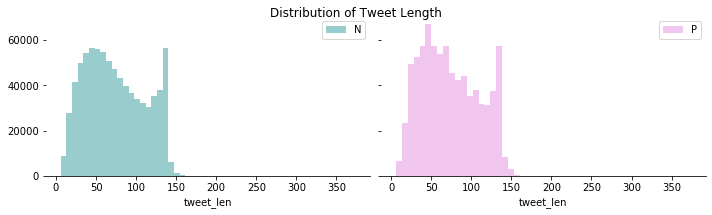

In [5]:
f, axes = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)
sns.despine(left=True)
sns.distplot(noemo['tweet_len'][noemo.polarity == 0], color='teal', kde=False, ax=axes[0],bins=50)
axes[0].legend('Negative')
sns.distplot(noemo['tweet_len'][noemo.polarity == 4], color='orchid',kde=False, ax=axes[1],bins=50)
axes[1].legend('Positive')
plt.suptitle('Distribution of Tweet Length')
plt.tight_layout()

#Comments: The distribution of tweet length is similar between negative and positive data. 

In [6]:
# as the dataset is large and nlp is slow, take about 40k (5%) samples from each category to explore the data 
neg_df = noemo[noemo.polarity==0].sample(frac=0.05)
posi_df = noemo[noemo.polarity==4].sample(frac=0.05)
toy_df = pd.concat((neg_df,posi_df))

In [20]:
# define functions to preprocess the texts

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import re
import pickle

def to_alpha(texts):
    """
    Take a string, remove website links, return only alphas
    """
    texts = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', texts)
    return(' '.join([w.lower() for w in nltk.word_tokenize(texts) if w.isalpha()]))
def token_lem_stem(texts,printout=None):
    """
    Take a string, do the following: 
    1. tokenize and lemmatize the tokens
    2. convert to stems 
    3. keep words longer than 2 characters
    """
    texts = to_alpha(texts)
    tokens = nltk.word_tokenize(texts)
    lemmatizer = WordNetLemmatizer()
    token_lem = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('English')]
    stemmer = SnowballStemmer("english")
    stemmed_words=[stemmer.stem(word) for word in token_lem]
    # keep words longer than 2
    words_len = [word for word in stemmed_words if len(word)>2]  
    if printout != None:
        print('No. of unique words \nbefore processing:', len(set(stemmed_words)))
        print('after processing:', len(set(words_len)))
        
    return words_len
    

In [25]:
#Try out the function "token_lem_stem"
toy_df['tweet'].head(5).apply(token_lem_stem)

415485                 [way, airport, head, home, bit, sad]
237662    [upyourbracket, aahh, wish, could, shower, thi...
158640    [sammyistheshizz, haha, trust, meee, toooo, ov...
618634                 [wish, exam, tomorrow, tuesday, fun]
438992                              [need, follow, hahahah]
Name: tweet, dtype: object

In [78]:
# apply "token_lem_stem", keep the results in a new column called 'tokens'
toy_df['tokens'] = toy_df['tweet'].apply(token_lem_stem)
toy_df.to_csv('data/toy_df.csv')

In [47]:
# Merge all rows into a large string for word frequency analysis
neg_bits = [a for b in toy_df['tokens'][toy_df.polarity == 0].tolist() for a in b]
posi_bits = [a for b in toy_df['tokens'][toy_df.polarity == 4].tolist() for a in b]

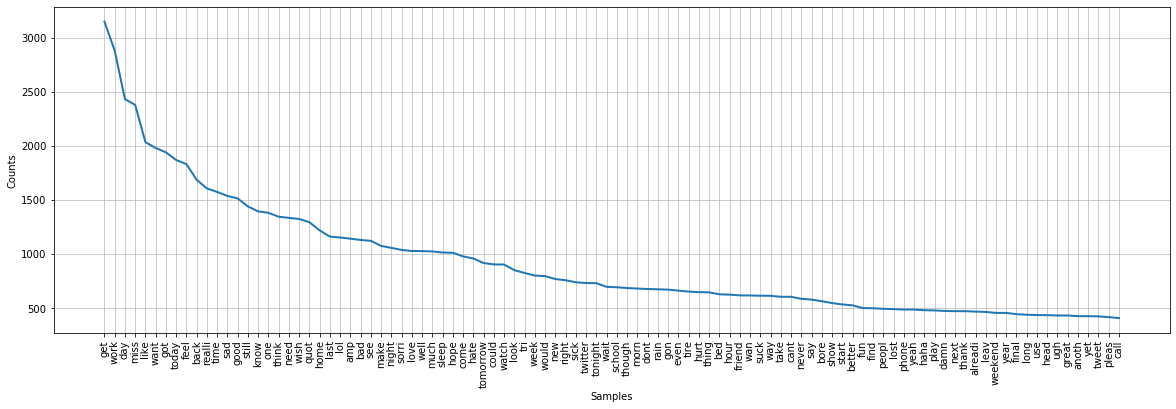

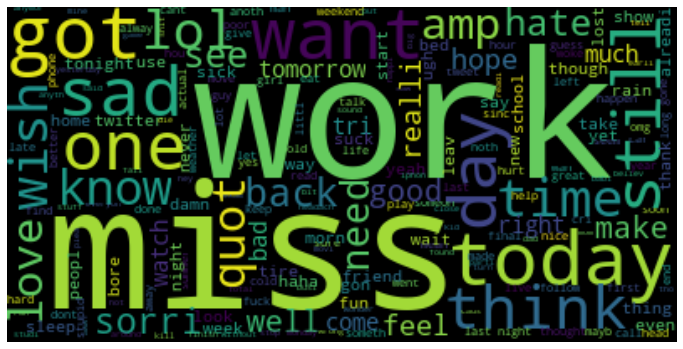

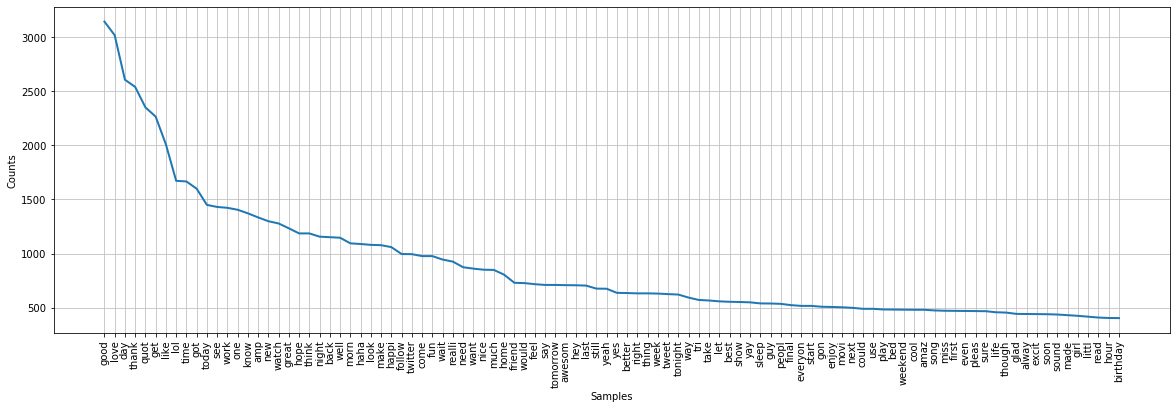

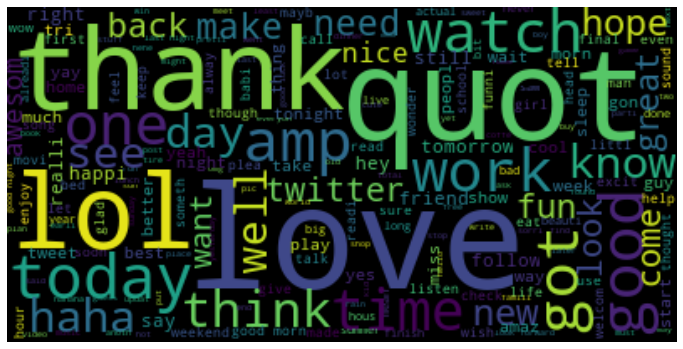

In [48]:
# find and plot common words in each category
from wordcloud import WordCloud

neg_fdist = nltk.FreqDist(neg_bits)
posi_fdist = nltk.FreqDist(posi_bits)
 
plt.figure(figsize = (20,6))
neg_fdist.plot(100)
wcloud = WordCloud(margin=0).generate(" ".join(neg_bits))
plt.figure(figsize = (12, 8))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,6))
posi_fdist.plot(100)
wcloud = WordCloud(margin=0).generate(" ".join(posi_bits))
plt.figure(figsize = (12, 8))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()




In [49]:
# sort the words according to their frequenc
neg_key_sorted= sorted(neg_fdist , key = neg_fdist.__getitem__, reverse = True)
posi_key_sorted = sorted(posi_fdist , key = posi_fdist.__getitem__, reverse = True)

In [51]:
# find words unique to each category among the top 100 words
n_wd= 100
neg_unique = [i for i in neg_key_sorted[:n_wd] if i not in posi_key_sorted[:n_wd]]
posi_unique = [i for i in posi_key_sorted[:n_wd] if i not in neg_key_sorted[:n_wd]]
print('The No. of unique words among top 100 words: '+str(len(neg_unique)))
neg_unique_fdist = [neg_fdist[i] for i in neg_unique]
posi_unique_fdist = [posi_fdist[i] for i in posi_unique]

The No. of unique words among top 100 words: 29


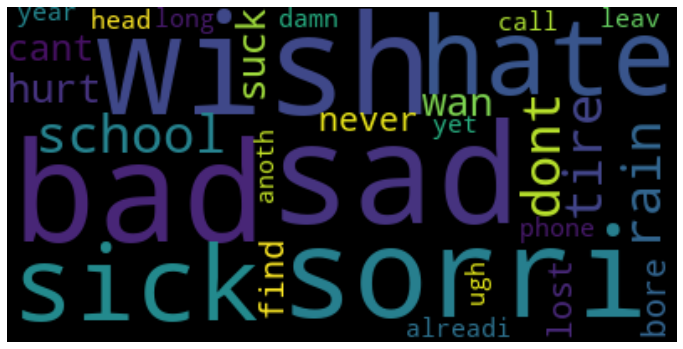

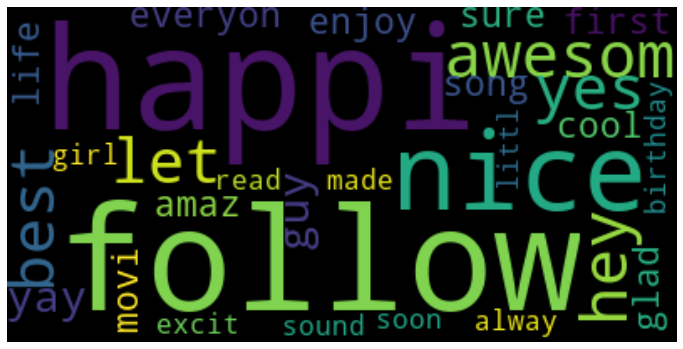

In [52]:
# do wordcloud to show unique words in each category
from wordcloud import WordCloud

for i in [neg_unique,posi_unique]:    
    wcloud = WordCloud(margin=0).generate(" ".join(i))
    plt.figure(figsize = (12, 8))
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Comments 
Among the top 100 words, there are 29 words unique to each category. Most of these words align with their respective categories. However, there are some potential misalignments, for instance, the word "made" is in the Positive category, but it's hard to understand why it's associated with positivity. 

Another drawback is that unigram analysis doesn't pick up polarity expressed by phrases. For instance, the most frequent word in the Positive category is "good",  but this word is also among the top 100 word in the Negative category, potentially because it's present in the phrase "not good". 




In [73]:
from sklearn.feature_extraction.text import CountVectorizer

# To directly use tokenized data, create a dummy function as analyzer
def dummy(tokens):
    return tokens

# take a while
toy_CV = CountVectorizer(analyzer = dummy).fit(toy_df.tokens)

# Print total number of vocab words
print(len(toy_CV.vocabulary_))

# transform 
toy_bow = toy_CV.transform(toy_df.tokens)

57142


In [74]:
from sklearn.feature_extraction.text import TfidfTransformer

toy_tfidf_transformer = TfidfTransformer().fit(toy_bow)
toy_tfidf = toy_tfidf_transformer.transform(toy_bow)

In [89]:
from sklearn.model_selection import train_test_split

tweet_train, tweet_test, pol_train, pol_test = train_test_split(toy_tfidf, toy_df.polarity, test_size=0.2)

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
NBmodel = MultinomialNB().fit(tweet_train, pol_train)
NBpredictions = NBmodel.predict(tweet_test)
print (classification_report(pol_test, NBpredictions))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8016
           4       0.75      0.69      0.72      7984

    accuracy                           0.73     16000
   macro avg       0.74      0.73      0.73     16000
weighted avg       0.74      0.73      0.73     16000



In [90]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression().fit(tweet_train, pol_train)
logpredictions = logmodel.predict(tweet_test)

print (classification_report(pol_test, logpredictions))

C:\Users\Huayi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.73      0.75      7867
           4       0.75      0.78      0.76      8133

    accuracy                           0.76     16000
   macro avg       0.76      0.75      0.75     16000
weighted avg       0.76      0.76      0.75     16000



## comments
The Naive Bayes classifier and the Logistic Regression classifier performed very similarly. Logistic Regression classifier seems a tiny bit better. For the final classification, use Logistic Regression. 

## Classify the whole dataset

Run Logistic Regression on the entire dataset. 

In [94]:
# apply "token_lem_stem", keep the results in a new column called  'tokens'
noemo['tokens'] = noemo['tweet'].apply(token_lem_stem)
noemo.to_csv('data/noemo.csv')

In [95]:
from sklearn.model_selection import train_test_split

tweet_train, tweet_test, pol_train, pol_test = train_test_split(noemo['tokens'], noemo['polarity'], test_size=0.2)

In [96]:
from sklearn.pipeline import Pipeline

# create a pipeline 
pipeline = Pipeline([ ('CV', CountVectorizer(analyzer=dummy)), 
                    ('tfidf', TfidfTransformer()),  
                    ('classifier', LogisticRegression()),])

In [97]:
pipeline.fit(tweet_train,pol_train)

C:\Users\Huayi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function dummy at 0x0000026CB9AD4840>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 to...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [98]:
predictions = pipeline.predict(tweet_test)
print(classification_report(predictions,pol_test))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77    153498
           4       0.79      0.76      0.78    166502

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

